In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

import os

filename = 'raw_tweets_queens_death.xlsx'
search_path = '/content/drive/My Drive'

file_path = None
for root, dirs, files in os.walk(search_path):
    if filename in files:
        file_path = os.path.join(root, filename)
        break
    df = pd.read_excel(file_path)


In [ ]:
df = pd.read_excel(file_path)
df.head()

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,...,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,1568087014423099904,1568035640071140096,2022-09-09 04:00:52 UTC,2022-09-09,04:00:52,0,1548680186832600064,jasonkhumaloii,DonOne,NaN,...,NaN,NaN,NaN,NaN,NaN,"{'user_id': '929512031224336384', 'username': ...",NaN,NaN,NaN,NaN
1,1568087013898820096,1568087013898820096,2022-09-09 04:00:52 UTC,2022-09-09,04:00:52,0,1142877206907160064,therhancock19,Itâ€™s Ryne,NaN,...,NaN,NaN,NaN,NaN,NaN,"{'user_id': None, 'username': None}",NaN,NaN,NaN,NaN
2,1568087009473989888,1568087009473989888,2022-09-09 04:00:51 UTC,2022-09-09,04:00:51,0,1546215928857299968,lucky694321,Wyles & Lucky,NaN,...,NaN,NaN,NaN,NaN,NaN,"{'user_id': None, 'username': None}",NaN,NaN,NaN,NaN
3,1568087009184329984,1568087009184329984,2022-09-09 04:00:51 UTC,2022-09-09,04:00:51,0,1515708479608130048,djdanstarbwoy,Dj Dan Starboy,NaN,...,NaN,NaN,NaN,NaN,NaN,"{'user_id': None, 'username': None}",NaN,NaN,NaN,NaN
4,1568087008446139904,1568087008446139904,2022-09-09 04:00:51 UTC,2022-09-09,04:00:51,0,1435263981409659904,yournewsobsess1,YourNewsObsession | Celebrity Gossip Blog,NaN,...,NaN,NaN,NaN,NaN,NaN,"{'user_id': None, 'username': None}",NaN,NaN,NaN,NaN


In [ ]:
df.isna().sum()

id                      0
conversation_id         0
created_at              0
date                    0
time                    0
timezone                0
user_id                 0
username                0
name                   71
place              601783
tweet                   1
language                0
mentions                0
urls                    0
photos                  0
replies_count           0
retweets_count          0
likes_count             0
hashtags                0
cashtags                0
link                    0
retweet            602359
quote_url          553837
video                   0
thumbnail          397772
near               602359
geo                602359
source             602359
user_rt_id         602359
user_rt            602359
retweet_id         602359
reply_to                0
retweet_date       602359
translate          602359
trans_src          602359
trans_dest         602359
dtype: int64

In [ ]:
# User with maximimum tweets
user_with_most_retweets = df.sort_values(by='retweets_count', ascending=False)['username'].iloc[0]
name = df.sort_values(by='retweets_count', ascending=False)['name'].iloc[0]
print("User with the most retweets:", user_with_most_retweets)
print("Name of the user with most tweets:", name)

User with the most retweets: ycsm1n
Name of the user with most tweets: yasmin


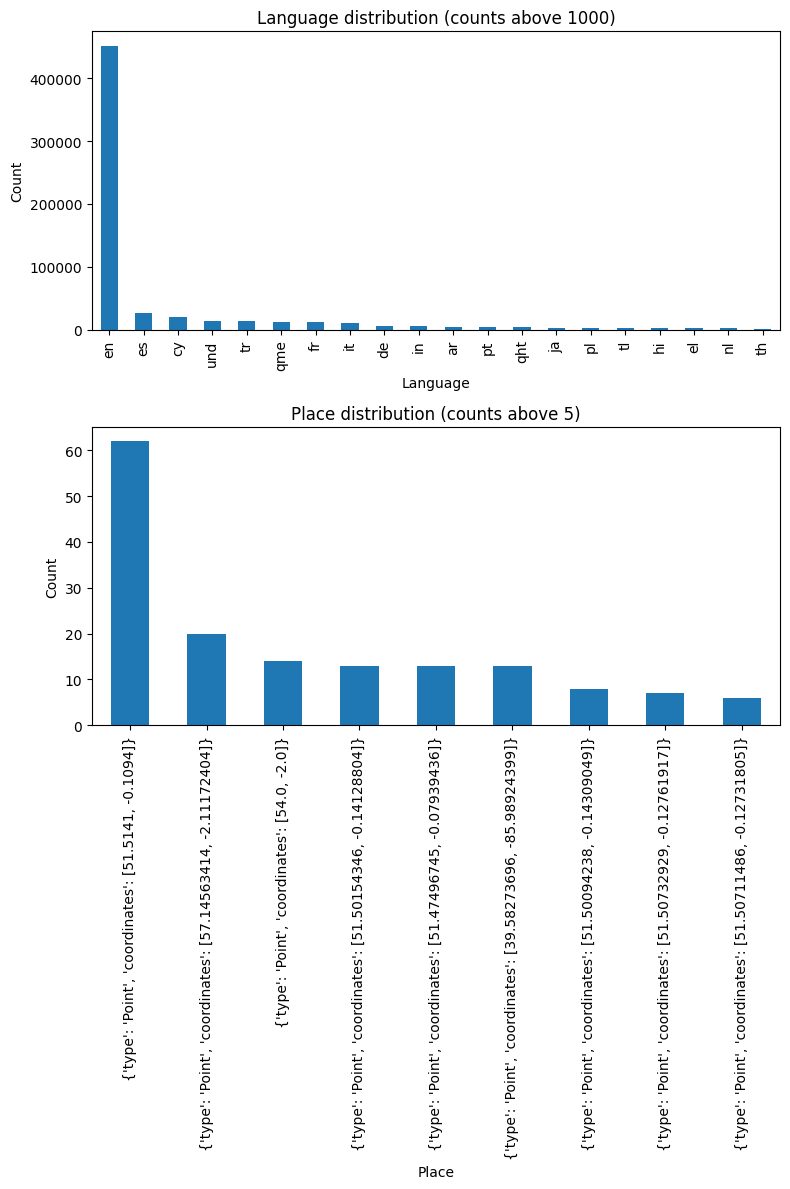

In [ ]:
language_threshold = 1000
place_threshold = 5

# Filter values above the threshold
filtered_languages = df['language'].value_counts()[df['language'].value_counts() > language_threshold]
filtered_places = df['place'].value_counts()[df['place'].value_counts() > place_threshold]

# Plot filtered values
plt.figure(figsize=(8, 12))

plt.subplot(2, 1, 1)
filtered_languages.plot(kind='bar')
plt.title(f"Language distribution (counts above {language_threshold})")
plt.xlabel('Language')
plt.ylabel('Count')

plt.subplot(2, 1, 2)
filtered_places.plot(kind='bar')
plt.title(f"Place distribution (counts above {place_threshold})")
plt.xlabel('Place')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

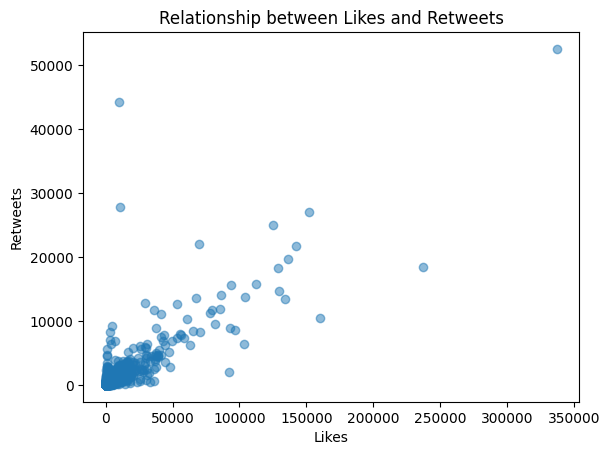

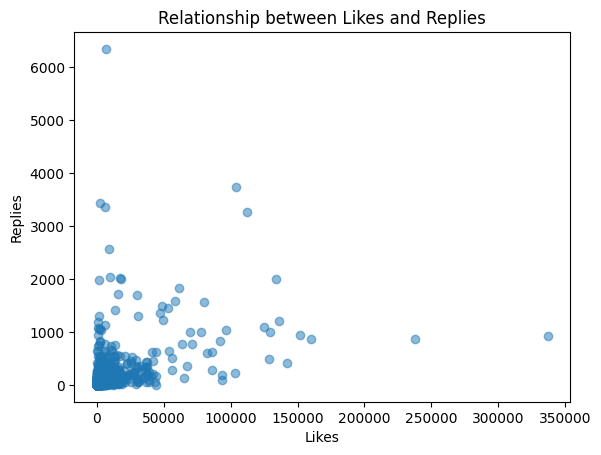

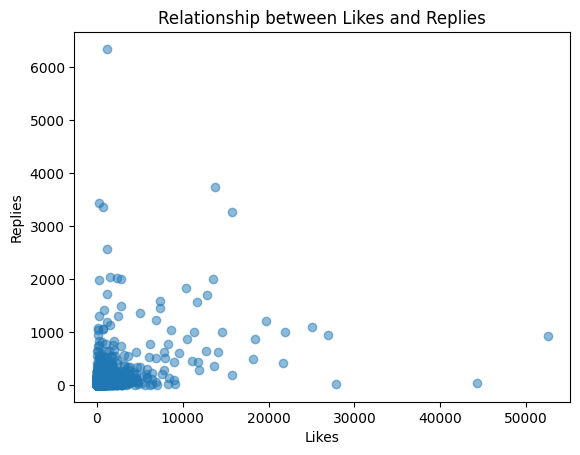

In [ ]:
plt.scatter(df['likes_count'], df['retweets_count'], alpha=0.5)
plt.xlabel('Likes')
plt.ylabel('Retweets')
plt.title('Relationship between Likes and Retweets')
plt.show()

plt.scatter(df['likes_count'], df['replies_count'], alpha=0.5)
plt.xlabel('Likes')
plt.ylabel('Replies')
plt.title('Relationship between Likes and Replies')
plt.show()

plt.scatter(df['retweets_count'], df['replies_count'], alpha=0.5)
plt.xlabel('Likes')
plt.ylabel('Replies')
plt.title('Relationship between Likes and Replies')
plt.show()

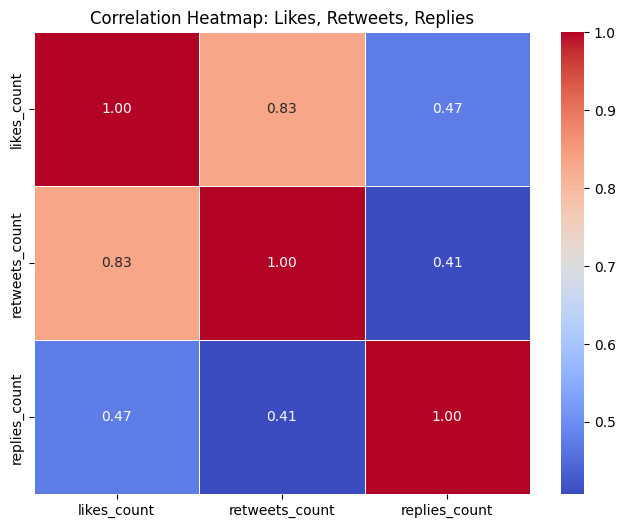

In [ ]:
selected_columns = df[['likes_count', 'retweets_count', 'replies_count']]

correlation_matrix = selected_columns.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap: Likes, Retweets, Replies')
plt.show()

Mean Squared Error: 4.200324918494907e-06


<Figure size 1000x800 with 0 Axes>

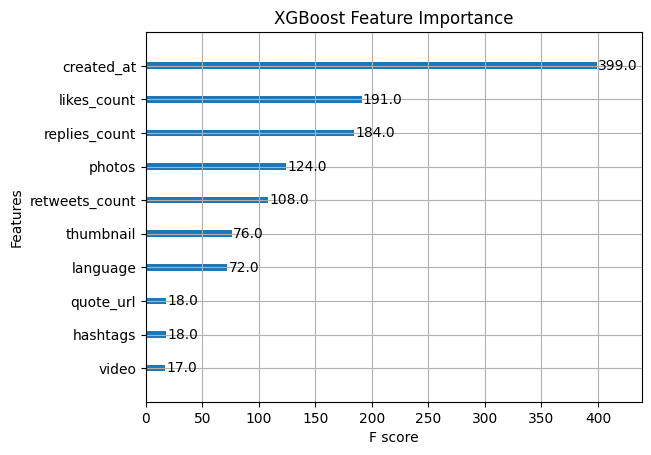

In [ ]:
from xgboost import XGBRegressor, XGBClassifier, plot_importance
from sklearn.metrics import mean_squared_error, roc_auc_score
import numpy as np

df1 = df.copy()

# Data preprocessing
leaky_features = ['id', 'conversation_id', 'user_id', 'date', 'time', 'username', 'name', 'tweet', 'link']
df1.drop(columns=leaky_features, inplace=True)
df1.fillna(0, inplace=True)

# Normalize the counts
df1['likes_count_norm'] = df1['likes_count'] / df1['likes_count'].max()
df1['retweet_count_norm'] = df1['retweets_count'] / df1['retweets_count'].max()
df1['replies_count_norm'] = df1['replies_count'] / df1['replies_count'].max()

# Define weights for each count
weight_likes = 0.6
weight_retweet = 0.3
weight_replies = 0.1

# Combine counts with weights to create a new target variable
df1['target'] = (weight_likes * df1['likes_count_norm'] +
                weight_retweet * df1['retweet_count_norm'] +
                weight_replies * df1['replies_count_norm'])

# Convert object types to categorical or drop them if not useful
for col in df1.select_dtypes(include='object').columns:
    df1[col] = df1[col].astype('category').cat.codes

# Auto detect categorical and continuous variables
likely_cat = {}
for var in df1.columns:
    likely_cat[var] = 1. * df1[var].nunique() / df1[var].count() < 0.05

cats = [var for var in df1.columns if likely_cat[var]]
conts = [var for var in df1.columns if not likely_cat[var]]

# Select target variable
target = 'target'  # Use the newly created target variable
if target in conts:
    conts.remove(target)
if target in cats:
    cats.remove(target)
df1[target] = df1[target].astype(float)

# Shuffle data
SHUFFLE_DATA = True
if SHUFFLE_DATA:
    df1 = df1.sample(frac=1).reset_index(drop=True)

# Split data
train_size = int(0.8 * len(df))
train_df = df1[:train_size]
valid_df = df1[train_size:]

X_train, y_train = train_df.drop(columns=[target]), train_df[target]
X_valid, y_valid = valid_df.drop(columns=[target]), valid_df[target]

# Train XGBoost model
if df1[target].nunique() > 2:
    model = XGBRegressor()
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    mse = mean_squared_error(y_valid, preds)
    print(f'Mean Squared Error: {mse}')
else:
    model = XGBClassifier()
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    auc = roc_auc_score(y_valid, preds)
    print(f'ROC AUC Score: {auc}')

# Feature importance
plt.figure(figsize=(10, 8))
plot_importance(model, max_num_features=10)
plt.title('XGBoost Feature Importance')
plt.show()

In [ ]:
for minimum_likes_threshold in range(0,101,10):
    with_video_likes = round(df[(df['video'] == 1) & (df['likes_count'] >= minimum_likes_threshold)]['likes_count'].mean(),2)
    without_video_likes = round(df[(df['video'] == 0) & (df['likes_count'] >= minimum_likes_threshold)]['likes_count'].mean(),2)
    print(f"Threshold of {minimum_likes_threshold} likes")
    print(f"Average likes with videos: {with_video_likes}")
    print(f"Average likes without videos : {without_video_likes}\n")


Threshold of 0 likes
Average likes with videos: 46.64
Average likes without videos : 17.03

Threshold of 10 likes
Average likes with videos: 253.9
Average likes without videos : 220.46

Threshold of 20 likes
Average likes with videos: 399.63
Average likes without videos : 388.92

Threshold of 30 likes
Average likes with videos: 518.75
Average likes without videos : 530.86

Threshold of 40 likes
Average likes with videos: 621.62
Average likes without videos : 660.72

Threshold of 50 likes
Average likes with videos: 711.36
Average likes without videos : 777.55

Threshold of 60 likes
Average likes with videos: 800.29
Average likes without videos : 883.7

Threshold of 70 likes
Average likes with videos: 880.2
Average likes without videos : 993.98

Threshold of 80 likes
Average likes with videos: 958.55
Average likes without videos : 1098.75

Threshold of 90 likes
Average likes with videos: 1034.41
Average likes without videos : 1195.7

Threshold of 100 likes
Average likes with videos: 1106

In [ ]:
# Q2
df2 = df.copy()
effectiveness_scores = model.predict(X_valid)
df2['likes_count_norm'] = df1['likes_count'] / df1['likes_count'].max()
df2['retweet_count_norm'] = df1['retweets_count'] / df1['retweets_count'].max()
df2['replies_count_norm'] = df1['replies_count'] / df1['replies_count'].max()


predicted_scores = (effectiveness_scores *
                    (weight_likes * df2['likes_count_norm'].values[:len(effectiveness_scores)] +
                     weight_retweet * df2['retweet_count_norm'].values[:len(effectiveness_scores)] +
                     weight_replies * df2['replies_count_norm'].values[:len(effectiveness_scores)]))

most_effective_index = np.argmax(predicted_scores)
most_effective_tweet = df2.iloc[most_effective_index]['tweet']
print("Most effective tweet:\n", most_effective_tweet)

Most effective tweet:
 Mientras #QueenElizabeth vio todos los mundiales de fÃºtbol, en MÃ©xico tenemos a Chabelita LÃ³pez que ha visto 17 MUNDIALES!!! https://t.co/jRfNwUWIsM
